In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import warnings

from sklearn.exceptions import ConvergenceWarning
from src.xic.graphical_lasso import GraphicalLassoEBIC, GraphicalLassoAIC
from src.ulnml.graphical_lasso import GraphicalURSC
from src.common.generator import GaussianCorrelation

In [6]:
import multiprocessing as mp
import joblib as jl
from itertools import groupby, product
from functools import reduce, partial
import operator as op
from toolz import curry, juxt, compose, identity

# func utils

assert curry(lambda a, b, c: a + b + c)(1)(2)(3) == 6
assert compose(lambda x: x * 2, lambda x: x - 1)(42) == 82


@curry
def apply(f, g, x):
    return f(g(x))

assert apply(lambda x: x * 2)(lambda x: x - 1)(42) == 82


class star:
    def __init__(self, func):
        self.func = func
    def __call__(self, args):
        return self.func(*args)

assert star(lambda a, b: a + b)([1, 2]) == 3

map1 = curry(__builtin__.map)
filter1 = curry(__builtin__.filter)
reduce1 = curry(reduce)

@curry
def map_parallel(n_jobs, func, iterable, verbose=0):
    return jl.Parallel(n_jobs=n_jobs, verbose=verbose)(
        jl.delayed(func)(x) for x in iterable
    )

assert list(map1(lambda x: x + 1)([1, 1, 2, 3, 5])) == [2, 2, 3, 4, 6]
assert map_parallel(-1)(op.neg)([1, 1, 2, 3, 5]) == [-1, -1, -2, -3, -5]
assert reduce1(op.add)(range(10)) == sum(range(10))


def fst(tup):
    return tup[0]

def snd(tup):
    return tup[1]

assert fst((1, 2)) == 1
assert snd((1, 2)) == 2


@curry
def over_fst(func, tup):
    return (func(fst(tup)),) + tup[1:]

@curry
def over_snd(func, tup):
    return (fst(tup), func(snd(tup))) + tup[2:]

assert over_fst(lambda x: x + 1)((1, 2)) == (2, 2)
assert over_snd(lambda x: x + 1)((1, 2)) == (1, 3)


# dictionary tools
# dict to association list
@curry
def lookup(dct, x):
    return dct[x]

assert lookup({1: 2, 3: 42})(3) == 42


undict = dict.items
freeze = compose(frozenset, undict)

assert compose(dict, undict)({1: 2, 3: 4}) == {1: 2, 3: 4}
assert compose(list, undict, dict)([(1, 2), (3, 4)]) == [(1, 2), (3, 4)]
assert compose(dict, freeze)({1: 2, 3: 4}) == {1: 2, 3: 4}
assert compose(list, freeze, dict)([(1, 2), (3, 4)]) == [(1, 2), (3, 4)]


def map_value(func, map=map1):
    return compose(dict, map(over_snd(func)), undict)

def starmap_value(func, map=map1):
    return map_value(star(func), map=map)

assert map_value(lambda x: x * 2)({1: 2, 3: 4}) == {1: 4, 3: 8}
assert map_value(op.neg, map=map_parallel(-1))({1: 2, 3: 4}) == {1: -2, 3: -4}
assert starmap_value(op.add)({1: (2, 3), 4: (5, 6)}) == {1: 5, 4: 11}
assert starmap_value(op.add, map=map_parallel(-1))({1: (2, 3), 4: (5, 6)}) == {1: 5, 4: 11}


def filter_by_key(key_pred):
    return compose(dict, filter1(compose(key_pred, fst)), undict)

assert filter_by_key(lambda x: x > 2)({1: 2, 3: 4}) == {3: 4}


def zip_value(*dicts):
    common_keys = compose(list, reduce1(set.intersection), map1(compose(set, dict.keys))) (dicts)
    value_getter = juxt(*map1(lookup)(dicts))
    return compose(map_value(value_getter), dict) (zip(common_keys, common_keys))

def product_dict(*dicts):
    return compose(dict, map1(compose(tuple, star(zip))), star(product), map1(undict)) (dicts)

@curry
def group_to_dict(keyfunc, lst):
    keyassocs = groupby(sorted(lst, key=keyfunc), key=keyfunc)
    return compose(dict, map1(over_snd(list))) (keyassocs)

@curry
def map_key(func, dct):
    keymap = compose(group_to_dict(func), dict.keys) (dct)
    return map_value(compose(list, map1(lookup(dct)))) (keymap)

assert zip_value({1: 2, 3: 4}, {1: 6, 3: 4}) == {1: (2, 6), 3: (4, 4)}
assert product_dict({1: 2, 3: 4}, {'a': 'b', 'c': 'd'}) == {(1, 'a'): (2, 'b'), (1, 'c'): (2, 'd'), (3, 'a'): (4, 'b'), (3, 'c'): (4, 'd')}
assert map_value(list)(group_to_dict(lambda x: x % 2)(range(10))) == {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}
assert map_key(lambda x: x % 2)(dict(zip(range(10), range(10)))) == {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}


# application

def plot_dict(dct, *args, **kwargs):
    keys, values = zip(*sorted(dct.items()))
    plt.plot(keys, values, *args, **kwargs)
    
def plot_dict_uncertainty(data, color, *args, k=1, **kwargs):
    mean = map_value(np.mean)(data)
    std_k = map_value(lambda xs: k * np.std(xs))(data)
    upper = starmap_value(op.add)(zip_value(mean, std_k))
    lower = starmap_value(op.sub)(zip_value(mean, std_k))
    x = sorted(mean.keys())
    map_lookup = compose(apply(list), map1, lookup)
    plt.fill_between(x, map_lookup(lower)(x), map_lookup(upper)(x), alpha=0.1, facecolor=color, edgecolor=color)
    plt.plot(x, map_lookup(mean)(x), *args, color=color, **kwargs)


In [7]:
""" Table (=list of dictionaries) manipulation """
import toolz


def table_example():
    return [{"name": "Nanami", "age": 36}, {"name": "Michael", "age": 12}]
assert table_example() is not None


def add_field(table, key, values):
    assert len(table) == len(values)
    return [toolz.assoc(rec, key, val) for rec, val in zip(table, values)]
assert (
    add_field(table_example(), "country", ["US", "Japan"])
    == [{"name": "Nanami", "age": 36, "country": "US"}, {"name": "Michael", "age": 12, "country": "Japan"}]
)


def merge(table1, table2):
    assert len(table1) == len(table2)
    return [toolz.merge(rec1, rec2) for rec1, rec2 in zip(table1, table2)]
assert merge([{1: 2}, {3: 4}], [{5: 6}, {7: 8}]) == [{1: 2, 5: 6}, {3: 4, 7: 8}]

def get_column(table, key):
    return (toolz.get(key, rec, default=None) for rec in table)
assert list(get_column(table_example(), "age")) == [36, 12]


def sort_by(keys, table):
    _, sorted_table =zip(*sorted(zip(get_column(table, keys), table)))
    return list(sorted_table)
assert sort_by("age", table_example()) == [{"name": "Michael", "age": 12}, {"name": "Nanami", "age": 36}]

In [8]:
from copy import deepcopy
import warnings
from toolz import dicttoolz as dz
from toolz import curried as cz
import toolz as tz
import joblib as jl
from sklearn.covariance import GraphLassoCV

# persistent memory
memory = jl.Memory(cachedir="memory_jqq3ady", verbose=0)

# adapter

def _generate(truth, kwargs):
    n = kwargs["n"]
    seed = kwargs["seed"]
    g = GaussianCorrelation(
        n=n, dim=truth.shape[0], loc=np.zeros(truth.shape[0]), scale2=np.linalg.inv(truth), normalize=False,
        rng=np.random.RandomState(seed)
    )
    data = g.generate()
    prec_cv = GraphLassoCV().fit(g._X).precision_
    return {"data": (data["n"], data["correlation"]), "method": "CV", "learner": GraphLassoCV(), "result": prec_cv}
generate = memory.cache(_generate)

def _perform(learner, data):
    learner = deepcopy(learner)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        learner.fit(*data)
    return learner.result
perform = memory.cache(_perform)

def evaluate(metric, truth, result):
    return metric(truth, result)

# main

def experiment(truth, generators: list, learners: dict, metric):
    
    table_data_cv = jl.Parallel(n_jobs=-1, verbose=10)(
        jl.delayed(generate)(truth, rec_generator)
        for rec_generator in generators
    )
    table_gen_data_cv = merge(generators, table_data_cv)
    table_gen_data = [toolz.dissoc(rec, "method", "result", "learner") for rec in table_gen_data_cv]
    
    table = [
        toolz.merge(rec_learner, rec_gen_data)
        for rec_learner in learners
        for rec_gen_data in table_gen_data
    ]
    results = jl.Parallel(n_jobs=-1, verbose=10)(
        jl.delayed(perform)(rec["learner"], rec["data"])
        for rec in table
    )
    table = add_field(table, "result", results)
    
    table_with_cv = table + table_gen_data_cv
    scores = [
        evaluate(metric, truth, rec["result"])
        for rec in table_with_cv
    ]
    table_final = add_field(table_with_cv, "score", scores)
    
    return table_final

In [9]:
def make_prec_double_ring(dim):
    a = 1
    prec = np.eye(dim)
    K = 2
    for k in range(1, K + 1):
        prec.flat[k::dim + 1] = a / (2 * K) 
        prec.T.flat[k::dim + 1] = a / (2 * K) 
    prec.flat[dim - K: K * dim: dim + 1] = a / (2 * K) 
    prec.T.flat[dim - K: K * dim: dim + 1] = a / (2 * K)
    return prec

In [12]:
generators = [
    {"n": first * 10 ** ndigits, "seed": seed}
    for seed in range(10)
    for first in (1, 2, 4, 7)
    for ndigits in (1, 2, 3, 4, 5)
    if ndigits not in (1, )
]

_learners = {
    "BIC": GraphicalLassoEBIC(gamma=0),
    "EBIC": GraphicalLassoEBIC(gamma=1),
    "AIC": GraphicalLassoAIC(),
    "MDL-RS": GraphicalURSC(delta=-1, lam_init=0),
}
learners = [{"method": method, "learner": learner} for method, learner in _learners.items()]

def KL_divergence(p, q):
    return 0.5 * (np.sum(np.linalg.inv(p) * q) - p.shape[0]) + 0.5 * (np.log(np.linalg.det(p)) - np.log(np.linalg.det(q)))

_scores = sum([
    experiment(
        truth=make_prec_double_ring(dim),
        generators=generators,
        learners=learners,
        metric=KL_divergence
    )
    for dim in [10, 20, 50, 100]
], [])

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   37.9s finished
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1579s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks   

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  4.4min
[Paralle

In [13]:
_scores = [dz.assoc(rec, "m", rec["data"][1].shape[0]) for rec in _scores]

In [14]:
from itertools import cycle

def plot_n_vs_performance(dim, performance, label, color, **kwargs):
    data = compose(cz.map(juxt(cz.get("n"), cz.get("score"))),
                   cz.filter(lambda rec: rec["method"] == label and rec["m"] == dim)
                  ) (performance)
    data_grouped = compose(dict, cz.map(over_snd(compose(list, cz.map(cz.second))))) (groupby(sorted(data), key=cz.first))
    plot_dict_uncertainty(data_grouped, color, **kwargs, k=1, label=label)
    
def make_style(key):
    table = {
        "BIC": ":",
        "EBIC": ":",
        "AIC": "--",
        "CV": "--",
        "MDL-RS": "-",
    }
    for k in table:
        if key.startswith(k):
            return table[k]
    else:
        return "-"
    
learners_list = ["CV", "BIC", "EBIC",
                 "AIC",
                 # "uRSC0i",
                 "MDL-RS",
                 # "uRSChi"
                ]



def save_ns(dim, ylim=(1e-4, 20)):
    # plt.figure(figsize=(10, 10))
    plt.grid(True, which="major")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(100, 100000)
    plt.ylim(*ylim)

    colors = cycle("r g b c m y k".split())
    for c, k in zip(colors, learners_list):
        plot_n_vs_performance(dim, _scores, label=k, color=c, linestyle=make_style(k), marker=".")
    plt.legend()
    # plt.plot(10 ** np.arange(2, 6), 100 / 10 ** np.arange(2, 6), "r-.")
    plt.xlabel("Training samples")
    plt.ylabel("KL divergence")
    plt.tight_layout()
    plt.savefig("GraphicalLasso_chain2-25_m{}.pdf".format(dim))

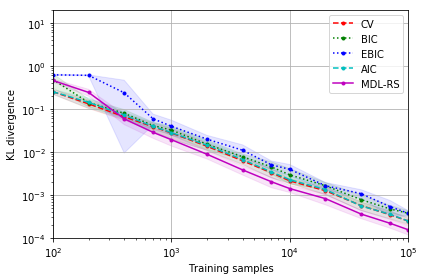

In [15]:
save_ns(10)

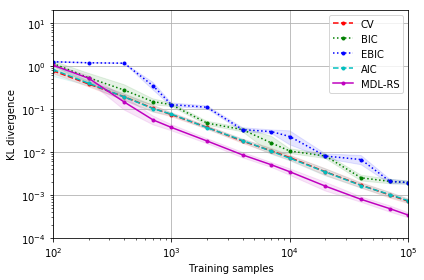

In [16]:
save_ns(20)

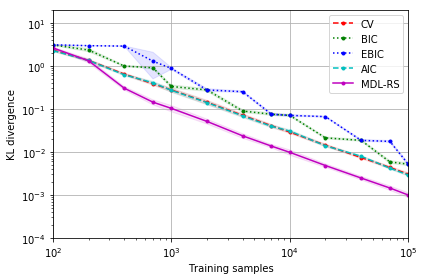

In [17]:
save_ns(50)

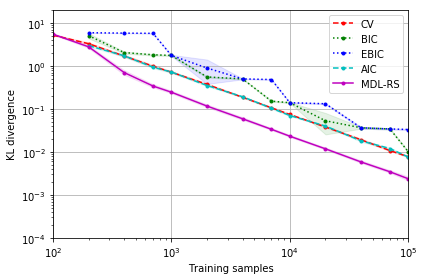

In [18]:
save_ns(100)